In [1]:
from __future__ import absolute_import, division, print_function
import torch
import torch.nn as nn


class CNN(nn.Module):
    def __init__(self, n_channels, n_classes):
        """
        Initializes CNN object.
        Args:
          n_channels: number of input channels
          n_classes: number of classes of the classification problem
        """
        super(CNN, self).__init__()

        # Define the layers as per the simplified VGG architecture
        self.conv_layers = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(
                128 * 7 * 7 , 1 * 1 * 512
            ),  # Adjust input size based on your data's resolution
            nn.ReLU(),
            nn.Linear(512, n_classes),
        )

    def forward(self, x):
        """
        Performs forward pass of the input.
        Args:
          x: input to the network
        Returns:
          out: outputs of the network
        """
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        # print(f"x_size:{x.shape}")
        out = self.fc_layers(x)
        return out


finish!
训练数据的形状: (50000, 3072)
训练标签的形状: (50000,)
train_label_shape:(50000,)
train_data_tensor:tensor([[0.2314, 0.1686, 0.1961,  ..., 0.5490, 0.3294, 0.2824],
        [0.6039, 0.4941, 0.4118,  ..., 0.5451, 0.5569, 0.5647],
        [1.0000, 0.9922, 0.9922,  ..., 0.3255, 0.3255, 0.3294],
        ...,
        [0.1373, 0.1569, 0.1647,  ..., 0.3020, 0.2588, 0.1961],
        [0.7412, 0.7294, 0.7255,  ..., 0.6627, 0.6706, 0.6706],
        [0.8980, 0.9255, 0.9176,  ..., 0.6784, 0.6353, 0.6314]],
       device='cuda:1')
train_label_tensor:tensor([6, 9, 9,  ..., 9, 1, 1], device='cuda:1')
Total batches: 1563
Epoch [2/100], Loss: 0.8190, Test Accuracy: 69.11%
Epoch [3/100], Loss: 0.8280, Test Accuracy: 72.14%
Epoch [4/100], Loss: 0.5874, Test Accuracy: 73.90%
Epoch [5/100], Loss: 0.8501, Test Accuracy: 76.90%
Epoch [6/100], Loss: 0.3462, Test Accuracy: 78.66%
Epoch [7/100], Loss: 0.4687, Test Accuracy: 77.27%
Epoch [8/100], Loss: 0.3025, Test Accuracy: 78.80%
Epoch [9/100], Loss: 0.2957, Test Accu

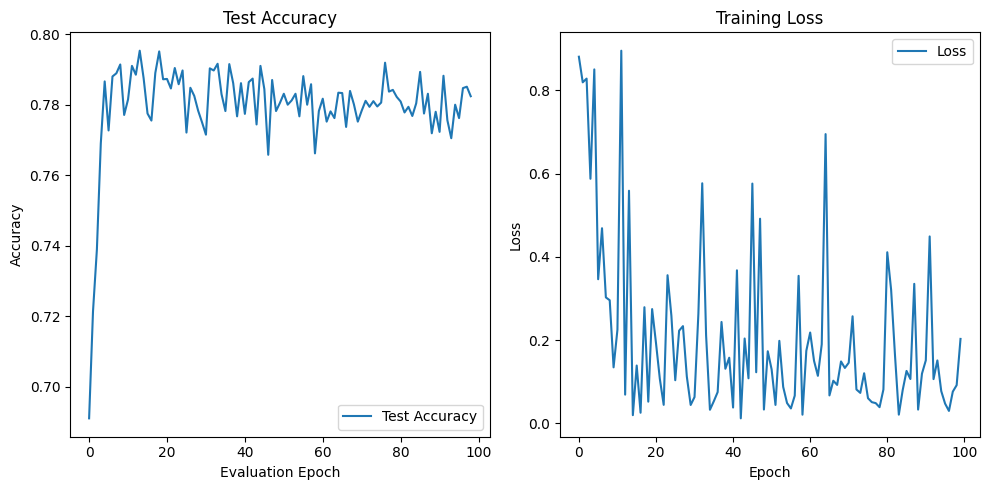

In [2]:
from __future__ import absolute_import, division, print_function
import argparse
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from cnn_model import CNN
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

# Default constants
LEARNING_RATE_DEFAULT = 0.0005
BATCH_SIZE_DEFAULT = 32
MAX_EPOCHS_DEFAULT = 100
EVAL_FREQ_DEFAULT = 10
OPTIMIZER_DEFAULT = "ADAM"
DECAY = 0.001
DATA_DIR_DEFAULT = "data/cifar-10-batches-py/"
FLAGS = None


def unpickle(file):
    import pickle

    with open(FLAGS.data_dir + file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict


def load_cifar10_data():
    # 需要加载的五个训练数据文件
    data_files = [
        "data_batch_1",
        "data_batch_2",
        "data_batch_3",
        "data_batch_4",
        "data_batch_5",
    ]

    # 初始化空列表用于存储数据和标签
    all_data = []
    all_labels = []

    # 逐个加载每个批次的数据
    for file in data_files:
        data_dict = unpickle(file)  # 加载数据文件
        all_data.append(data_dict[b"data"])  # 将数据部分添加到 all_data 中
        all_labels.append(data_dict[b"labels"])  # 将标签部分添加到 all_labels 中

    # 将数据合并成一个大的 NumPy 数组
    all_data = np.vstack(all_data)  # 合并所有数据
    all_labels = np.concatenate(all_labels)  # 合并所有标签

    return all_data, all_labels


def get_train_test_data(test_file):
    train_data, train_label = load_cifar10_data()

    print(f"训练数据的形状: {train_data.shape}")
    print(f"训练标签的形状: {train_label.shape}")

    test_data_batch = unpickle(test_file)

    test_data = test_data_batch[b"data"]
    test_label = test_data_batch[b"labels"]

    # trans to .array
    train_data = np.array(train_data)
    # print(f"train_data:{train_data.shape},{train_label}")
    train_label = np.array(train_label)
    # print(f"train_label:{train_label.shape},{train_label}")

    test_data = np.array(test_data)
    # print(f"test_data:{test_data.shape},{test_data}")
    test_label = np.array(test_label)
    # print(f"test_label:{test_label.shape},{test_label}")
    return train_data, train_label, test_data, test_label


def tensor_tranfer(train_data, train_label, test_data, test_label, device):
    # Convert training and testing data to PyTorch tensors
    train_data_tensor = torch.tensor(train_data, dtype=torch.float32).to(device)
    train_label_tensor = torch.tensor(train_label, dtype=torch.long).to(
        device
    )  # Convert to class indices
    test_data_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)
    test_label_tensor = torch.tensor(test_label, dtype=torch.long).to(device)
    return (
        train_data_tensor / 255,
        train_label_tensor,
        test_data_tensor / 255,
        test_label_tensor,
    )


def accuracy(predictions, targets):
    """
    Computes the prediction accuracy.
    Args:
        predictions: 2D float array of size [number_of_data_samples, n_classes]
        targets: 1D int array of size [number_of_data_samples] with ground-truth labels
    Returns:
        accuracy: scalar float, the accuracy of predictions.
    """
    _, predicted_labels = torch.max(predictions, 1)
    correct = (predicted_labels == targets).sum().item()
    accuracy = correct / targets.size(0)
    return accuracy


def train():
    """
    Performs training and evaluation of CNN model.
    """
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    test_file = "test_batch"

    train_data, train_label, test_data, test_label = get_train_test_data(test_file)

    print(f"train_label_shape:{train_label.shape}")

    train_data_tensor, train_label_tensor, test_data_tensor, test_label_tensor = (
        tensor_tranfer(train_data, train_label, test_data, test_label, device)
    )

    print(f"train_data_tensor:{train_data_tensor}")
    print(f"train_label_tensor:{train_label_tensor}")

    # dnn_hidden_units = list(map(int, FLAGS.dnn_hidden_units.split(",")))

    # print(f"dnn_units:{dnn_hidden_units}")

    # Initialize model, loss, and optimizer
    model = CNN(n_channels=3, n_classes=10).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(), lr=FLAGS.learning_rate, weight_decay=DECAY
    )
    
    # train_accuracies = []
    test_accuracies = []
    losses = []

    train_data_tensor = train_data_tensor.view(-1, 3, 32, 32)
    test_data_tensor = test_data_tensor.view(-1, 3, 32, 32)
    
    # Assume that train_loader and test_loader are initialized DataLoader objects
    train_dataset = TensorDataset(train_data_tensor, train_label_tensor)
    train_loader = DataLoader(train_dataset, batch_size=FLAGS.batch_size, shuffle=True)

    total_batches = len(train_loader)
    print(f"Total batches: {total_batches}")

    # test_loader = DataLoader(test_dataset, batch_size=FLAGS.batch_size, shuffle=False)

    # Training loop
    for epoch in range(FLAGS.max_steps):
        model.train()  # Set the model to training mode

        # print(f"epoch1:{epoch}")

        # print(f"train_loader:{train_loader}")

        for inputs, labels in train_loader:
            # inputs, labels = inputs.to(device), labels.to(device)
            # print(f"epoch1:{epoch}")

            # print(f"Inputs shape: {inputs.shape}")
            # print(f"Labels shape: {labels.shape}")
            
            # inputs = inputs.view(-1, 3, 32, 32)

            # print(f"epoch2:{epoch}")
            # Forward pass
            optimizer.zero_grad()
            # print("start")
            outputs = model(inputs)
            # print("end")
            loss = loss_fn(outputs, labels)
            # print(f"loss:{loss}")
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # print(f"epoch2:{epoch}")
        # Record the last batch loss for this epoch
        losses.append(loss.item())

        # Evaluate model performance on the test set every eval_freq epochs
        if epoch > 0:
            model.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                # train_predictions = model(train_data_tensor)
                test_predictions = model(test_data_tensor)

                # print(f"train_prediction:{train_predictions.shape},{train_predictions}")
                # print(f"train_prediction:{train_label.shape},{train_predictions}")

                # Compute accuracy
                # train_accuracy = accuracy(
                #     train_predictions.to(device), train_label_tensor.to(device)
                # )
                test_accuracy = accuracy(
                    test_predictions.to(device), test_label_tensor.to(device)
                )
                
                # train_accuracies.append(train_accuracy)
                test_accuracies.append(test_accuracy)
                print(
                    f"Epoch [{epoch + 1}/{FLAGS.max_steps}], "
                    f"Loss: {loss.item():.4f}, "
                    # f"Train Accuracy: {train_accuracy * 100:.2f}%, "
                    f"Test Accuracy: {test_accuracy * 100:.2f}%"
                )
    # Plot accuracy and loss
    plt.figure(figsize=(10, 5))

    # Plot training and test accuracy
    plt.subplot(1, 2, 1)
    # plt.plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy')
    plt.plot(range(len(test_accuracies)), test_accuracies, label='Test Accuracy')
    plt.xlabel('Evaluation Epoch')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(range(len(losses)), losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Save the plot
    plt.tight_layout()
    plt.savefig('accuracy_loss_plot_CNN.png')  # Save to local file
    print("Plot saved as accuracy_loss_plot_CNN.png")
    plt.show()


def main():
    """
    Main function
    """
    train()


if __name__ == "__main__":
    # Command line arguments
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--learning_rate",
        type=float,
        default=LEARNING_RATE_DEFAULT,
        help="Learning rate",
    )
    parser.add_argument(
        "--max_steps",
        type=int,
        default=MAX_EPOCHS_DEFAULT,
        help="Number of steps to run trainer.",
    )
    parser.add_argument(
        "--batch_size",
        type=int,
        default=BATCH_SIZE_DEFAULT,
        help="Batch size to run trainer.",
    )
    parser.add_argument(
        "--eval_freq",
        type=int,
        default=EVAL_FREQ_DEFAULT,
        help="Frequency of evaluation on the test set",
    )
    parser.add_argument(
        "--data_dir",
        type=str,
        default=DATA_DIR_DEFAULT,
        help="Directory for storing input data",
    )
    FLAGS, unparsed = parser.parse_known_args()

    main()
